In [1]:
# Import Stuff

import os
import torch
import random
import IPython
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt

from sklearn import svm
from IPython.display import display
import torchvision.transforms as transforms
from scipy.stats import describe, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

#from google.colab import drive # Add this if you are using google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## config

In [3]:
class CFG:
    # Some direction used
    BASE_DIR = os.path.join(os.getcwd(), "drive/MyDrive/HMS" )
    SAVE_DIR = os.path.join(os.getcwd(), "hms-harmful-brain-activity-classification/numpy")

    # Init dic that need to convert class to num
    class_lst       = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    class_label_dic = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
    label_class_dic = {0: 'Seizure', 1: 'LPD', 2: 'GPD', 3: 'LRDA', 4: 'GRDA', 5: 'Other'}

    # sample rate & frequency
    # The reason I use num_sample here, is you could use different chunk to train
    # Here i give you is the default = sample_freq_eeg * data_duration_eeg
    # but from my perspective data_duration_eeg better < 50
    sample_freq_eeg   = 200
    data_duration_eeg = 50
    num_sample_eeg    = sample_freq_eeg * data_duration_eeg

    sample_freq_spec  = 1/2
    data_duration_spec = 600
    num_sample_spec    = int(sample_freq_spec * data_duration_spec)

    # You could also choose to use different features for egg, there are 20 features in total
    # The one i give you is 8
    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2"]

    # data type
    egg_dtype  = "float32"
    spec_dtype = "float32"

    # seed
    seed = 42

    # batch size
    BATCH_SIZE = 64

    # device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

前50%

In [4]:
# import datas from csv file into pandas.core.fram.DataFrame data type
# you probably only need to chance the base_dir if you using different dir
print("Importing data from csv file ......")
df      = pd.read_csv(os.path.join(CFG.BASE_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(CFG.BASE_DIR, "test.csv"))
id = np.unique(df['spectrogram_id'])
id = id[0:int(len(id)/2)]
df = df[df['spectrogram_id'].isin(id)]
print("Finish Importing.\n")

# If you would like to save files, i already created two folders
os.makedirs(os.path.join(CFG.BASE_DIR, 'train_spectrograms'), exist_ok=True)
os.makedirs(os.path.join(CFG.BASE_DIR, 'test_spectrograms'),  exist_ok=True)

Importing data from csv file ......
Finish Importing.



后50%

In [4]:
print("Importing data from csv file ......")
df      = pd.read_csv(os.path.join(CFG.BASE_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(CFG.BASE_DIR, "test.csv"))
id = np.unique(df['spectrogram_id'])
id = id[int(len(id)/2):]
df = df[df['spectrogram_id'].isin(id)]
print("Finish Importing.\n")

# If you would like to save files, i already created two folders
os.makedirs(os.path.join(CFG.BASE_DIR, 'train_spectrograms'), exist_ok=True)
os.makedirs(os.path.join(CFG.BASE_DIR, 'test_spectrograms'),  exist_ok=True)

Importing data from csv file ......
Finish Importing.



## Data preprocessing

In [5]:
# Get EGG & spectrograms for each row, for both train and test
df['eeg_path']       = CFG.BASE_DIR + '/train_eegs/'         + df['eeg_id'].astype(str)         + '.parquet'
df['spec_path']      = CFG.BASE_DIR + '/train_spectrograms/' + df['spectrogram_id'].astype(str) + '.parquet'
df_test['eeg_path']  = CFG.BASE_DIR + '/test_eegs/'          + df['eeg_id'].astype(str)         + '.parquet'
df_test['spec_path'] = CFG.BASE_DIR + '/test_spectrograms/'  + df['spectrogram_id'].astype(str) + '.parquet'

# Create a new column that has the numerical value of label
df['label'] = df['expert_consensus'].map(CFG.class_label_dic)

### display dataframe for your interest
display(df.head())
display(df_test.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,label
53236,15238928,0,0.0,1052278850,0,0.0,3113428357,63749,Other,0,3,1,0,2,6,/content/drive/MyDrive/HMS/train_eegs/15238928...,/content/drive/MyDrive/HMS/train_spectrograms/...,5
53237,2072330160,0,0.0,1052322937,0,0.0,38657228,22195,GRDA,0,0,0,0,1,0,/content/drive/MyDrive/HMS/train_eegs/20723301...,/content/drive/MyDrive/HMS/train_spectrograms/...,4
53238,244209239,0,0.0,1052322937,1,258.0,2979230589,22195,GPD,0,0,1,0,0,0,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,2
53239,244209239,1,26.0,1052322937,2,284.0,1050784245,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4
53240,244209239,2,28.0,1052322937,3,286.0,3940459504,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path
0,853520,3911565283,6885,NaN,NaN


In [6]:
df['eeg_path']       = CFG.BASE_DIR + '/train_eegs/'         + df['eeg_id'].astype(str)         + '.parquet'
df['spec_path']      = CFG.BASE_DIR + '/train_spectrograms/' + df['spectrogram_id'].astype(str) + '.parquet'
df_test['eeg_path']  = CFG.BASE_DIR + '/test_eegs/'          + df['eeg_id'].astype(str)         + '.parquet'
df_test['spec_path'] = CFG.BASE_DIR + '/test_spectrograms/'  + df['spectrogram_id'].astype(str) + '.parquet'

# Create a new column that has the numerical value of label
df['label'] = df['expert_consensus'].map(CFG.class_label_dic)

### display dataframe for your interest
display(df.head())
display(df_test.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,label
53236,15238928,0,0.0,1052278850,0,0.0,3113428357,63749,Other,0,3,1,0,2,6,/content/drive/MyDrive/HMS/train_eegs/15238928...,/content/drive/MyDrive/HMS/train_spectrograms/...,5
53237,2072330160,0,0.0,1052322937,0,0.0,38657228,22195,GRDA,0,0,0,0,1,0,/content/drive/MyDrive/HMS/train_eegs/20723301...,/content/drive/MyDrive/HMS/train_spectrograms/...,4
53238,244209239,0,0.0,1052322937,1,258.0,2979230589,22195,GPD,0,0,1,0,0,0,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,2
53239,244209239,1,26.0,1052322937,2,284.0,1050784245,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4
53240,244209239,2,28.0,1052322937,3,286.0,3940459504,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path
0,853520,3911565283,6885,NaN,NaN


The number of training data: 53564
The number of test data:     1 



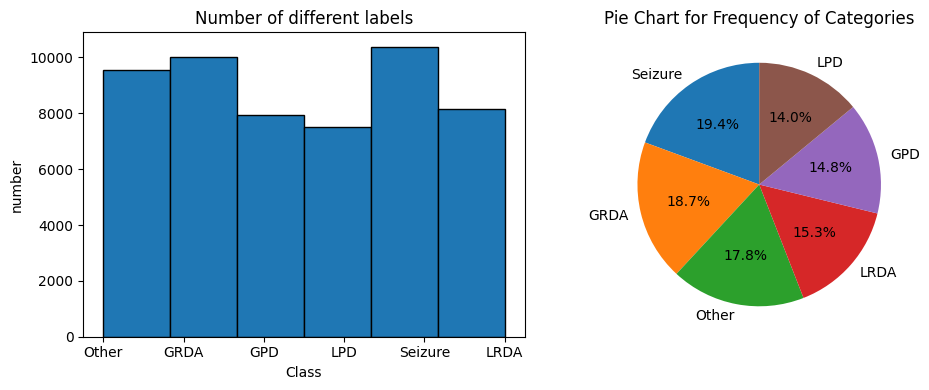

In [6]:
# Get some info
print("The number of training data: {}".format(df.shape[0]))
print("The number of test data:     {} \n".format(len(df_test)))

# Plot the histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['expert_consensus'], bins=len(CFG.class_lst), edgecolor='black')
plt.xlabel('Class')
plt.ylabel('number')
plt.title('Number of different labels')

# Plot the pie plot
plt.subplot(1, 2, 2)
value_counts = df['expert_consensus'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Frequency of Categories')
plt.tight_layout()
plt.show()

The number of training data: 53236
The number of test data:     1 



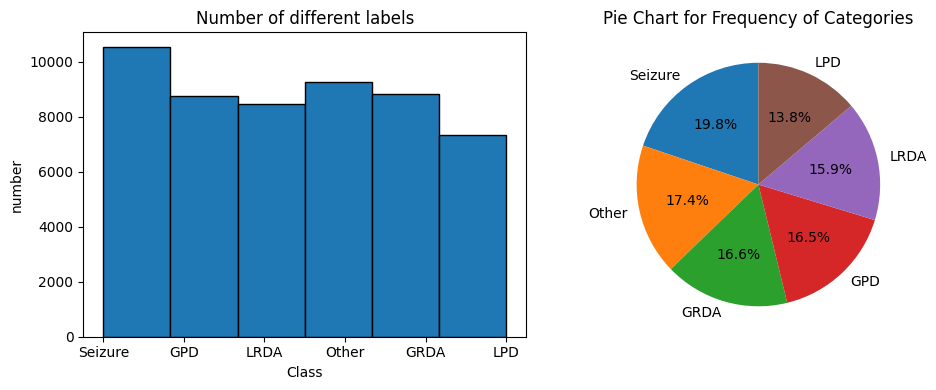

In [ ]:
# Get some info
print("The number of training data: {}".format(df.shape[0]))
print("The number of test data:     {} \n".format(len(df_test)))

# Plot the histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['expert_consensus'], bins=len(CFG.class_lst), edgecolor='black')
plt.xlabel('Class')
plt.ylabel('number')
plt.title('Number of different labels')

# Plot the pie plot
plt.subplot(1, 2, 2)
value_counts = df['expert_consensus'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Frequency of Categories')
plt.tight_layout()
plt.show()

### Split the data into training and validation

In [8]:
test_df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,label,fold
53240,244209239,2,28.0,1052322937,3,286.0,3940459504,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4,2
53243,2562093419,1,4.0,1052322937,6,476.0,148237023,22195,GPD,0,0,3,0,1,0,/content/drive/MyDrive/HMS/train_eegs/25620934...,/content/drive/MyDrive/HMS/train_spectrograms/...,2,2
53245,2562093419,3,8.0,1052322937,8,480.0,4255882875,22195,GPD,0,0,3,0,1,0,/content/drive/MyDrive/HMS/train_eegs/25620934...,/content/drive/MyDrive/HMS/train_spectrograms/...,2,2
53250,2543362912,0,0.0,1052814650,0,0.0,3141810341,13598,Other,0,0,0,1,2,9,/content/drive/MyDrive/HMS/train_eegs/25433629...,/content/drive/MyDrive/HMS/train_spectrograms/...,5,2
53265,1574297716,5,24.0,1053556305,5,24.0,3543331624,11579,Seizure,3,0,0,0,0,0,/content/drive/MyDrive/HMS/train_eegs/15742977...,/content/drive/MyDrive/HMS/train_spectrograms/...,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106784,1306668185,0,0.0,2147312808,0,0.0,1216355904,57480,LPD,0,3,0,0,0,0,/content/drive/MyDrive/HMS/train_eegs/13066681...,/content/drive/MyDrive/HMS/train_spectrograms/...,1,2
106793,351917269,4,8.0,2147388374,4,8.0,1374115633,10351,LRDA,0,0,0,3,0,0,/content/drive/MyDrive/HMS/train_eegs/35191726...,/content/drive/MyDrive/HMS/train_spectrograms/...,3,2
106794,351917269,5,10.0,2147388374,5,10.0,223739845,10351,LRDA,0,0,0,3,0,0,/content/drive/MyDrive/HMS/train_eegs/35191726...,/content/drive/MyDrive/HMS/train_spectrograms/...,3,2
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0,/content/drive/MyDrive/HMS/train_eegs/35191726...,/content/drive/MyDrive/HMS/train_spectrograms/...,3,2


In [7]:
# Splite the training data into training and validation data
# While tryiing to maintain the expert consensus balanced
# AFTER SPLITE: the folder number is assign to 0 to 9 (10 fold case)
n_splits   = 10
skf        = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CFG.seed)
df['fold'] = -1

for fold, (_, val_index) in enumerate(skf.split(df.index, df['expert_consensus'])):
    df.loc[df.index[val_index], 'fold'] = fold

val_index   = [1]
test_index  = [2]
train_index = [3,4,5,6,7,8,9]

train_df = df[df['fold'].isin(train_index)]
val_df   = df[df['fold'].isin(val_index)]
test_df  = df[df['fold'].isin(test_index)]

print(" The training data number is {}.\n The validation data number is {}.\n The testing data number is {}.".format(train_df.shape[0],
                                                                                                                    test_df.shape[0],
                                                                                                                    val_df.shape[0]))

 The training data number is 37493.
 The validation data number is 5357.
 The testing data number is 5357.


In [8]:
train_df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,label,fold
53236,15238928,0,0.0,1052278850,0,0.0,3113428357,63749,Other,0,3,1,0,2,6,/content/drive/MyDrive/HMS/train_eegs/15238928...,/content/drive/MyDrive/HMS/train_spectrograms/...,5,5
53237,2072330160,0,0.0,1052322937,0,0.0,38657228,22195,GRDA,0,0,0,0,1,0,/content/drive/MyDrive/HMS/train_eegs/20723301...,/content/drive/MyDrive/HMS/train_spectrograms/...,4,3
53238,244209239,0,0.0,1052322937,1,258.0,2979230589,22195,GPD,0,0,1,0,0,0,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,2,6
53239,244209239,1,26.0,1052322937,2,284.0,1050784245,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4,7
53241,244209239,3,30.0,1052322937,4,288.0,9870270,22195,GRDA,0,0,0,0,7,6,/content/drive/MyDrive/HMS/train_eegs/24420923...,/content/drive/MyDrive/HMS/train_spectrograms/...,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106790,351917269,1,2.0,2147388374,1,2.0,1916299616,10351,LRDA,0,0,0,3,0,0,/content/drive/MyDrive/HMS/train_eegs/35191726...,/content/drive/MyDrive/HMS/train_spectrograms/...,3,7
106791,351917269,2,4.0,2147388374,2,4.0,1085988029,10351,LRDA,0,0,0,3,0,0,/content/drive/MyDrive/HMS/train_eegs/35191726...,/content/drive/MyDrive/HMS/train_spectrograms/...,3,3
106792,351917269,3,6.0,2147388374,3,6.0,3808975447,10351,LRDA,0,0,0,3,0,0,/content/drive/MyDrive/HMS/train_eegs/35191726...,/content/drive/MyDrive/HMS/train_spectrograms/...,3,4
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0,/content/drive/MyDrive/HMS/train_eegs/35191726...,/content/drive/MyDrive/HMS/train_spectrograms/...,3,7


### Define my dataset

In [9]:
def parquet_to_eeg(eeg_path, offset):
    # In this function i simply modify the data by get rid of nan and set the dtype
    # the reason I use such a easy and simple function is becasuse it simply just load the parquet
    # I left pure and modification in the transform function
    # MORE job need to be done!
    eeg   = pd.read_parquet(eeg_path, columns=CFG.eeg_features)
    start = int(offset * CFG.sample_freq_eeg)
    end   = int(start + CFG.num_sample_eeg)
    egg   = eeg.iloc[start: end].fillna(0).values.astype(CFG.egg_dtype)
    return egg.T

In [10]:
def parquet_to_spec(spec_path, offset):
    # HERE, you can also load specific range of column by adding the second input
    spec  = pd.read_parquet(spec_path).iloc[:, 1:]
    start = int(np.floor(offset * CFG.sample_freq_spec))
    end   = start + CFG.num_sample_spec
    spec  = spec.iloc[start: end].fillna(0).values.astype(CFG.spec_dtype)
    return spec.T

In [11]:
# define my dataset
class MyDataset(Dataset):
    def __init__(self, dataframe, transform_egg=None, transform_spec=None,
                 transform_lab=None, transform_vote=None):
        self.dataframe      = dataframe
        self.transform_egg  = transform_egg
        self.transform_spec = transform_spec
        self.transform_lab  = transform_lab
        self.transform_vote = transform_vote

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        df          = self.dataframe.iloc[idx]
        eeg_path    = df["eeg_path"]
        spec_path   = df["spec_path"]
        eeg_offset  = df["eeg_label_offset_seconds"]
        spec_offset = df["spectrogram_label_offset_seconds"]

        vote        = df[['seizure_vote','lpd_vote','gpd_vote','lrda_vote','grda_vote', 'other_vote']].values.astype("int")
        label       = df['label']

        #eeg         = parquet_to_eeg(eeg_path, eeg_offset)
        spec        = parquet_to_spec(spec_path, spec_offset)
        #if self.transform_egg:
            #egg = self.transform_egg(eeg)[0]
        if self.transform_spec:
            spec = self.transform_spec(spec)[0]
        if self.transform_lab:
            label = self.transform_lab(label)[0]
        if self.transform_vote:
            vote = self.transform_vote(vote)[0]

        return spec, label, vote
        #egg,


In [12]:
# define the dataloader
# YOU could add more transformer, actaully i think that is a good start point to investigate
transform = transforms.Compose([transforms.ToTensor()])

train_dataset       = MyDataset(train_df, transform)
test_dataset        = MyDataset(test_df,   transform)
validation_dataset  = MyDataset(val_df,     transform)

# Define the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(validation_dataset, batch_size=16, shuffle=False)

In [13]:
def evaluate(model, dataloader, criterion, device):
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
      count = 0
      for images, labels, votes in dataloader:
        count += 64
        images, labels, votes = images.to(device), labels.to(device), votes.to(device)
        row_sums = votes.sum(dim=1, keepdim=True)
        normalized_x = votes / row_sums
        images = images.unsqueeze(1)
        outputs = model(images)
        loss = criterion(torch.log_softmax(outputs, dim=1), normalized_x)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        total_val += labels.size(0)
        #print(count)
        if count > 12000:
          break
      val_loss = val_loss / total_val
      val_accuracy = (val_correct / total_val)
      return val_loss, val_accuracy

Efficientnet Training:

pretrain the first 50% dataset

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
model = models.efficientnet_b0(pretrained=True)
first_conv_layer = model.features[0][0]
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model.features[0][0] = nn.Conv2d(1, first_conv_layer.out_channels,
                                        kernel_size=first_conv_layer.kernel_size,
                                        stride=first_conv_layer.stride,
                                        padding=first_conv_layer.padding,
                                        bias=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train on the second 50% dataset

In [14]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
model = models.efficientnet_b0(pretrained=False)
state_dict = torch.load('drive/MyDrive/HMS/efficientnet50.pth')
first_conv_layer = model.features[0][0]
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model.features[0][0] = nn.Conv2d(1, first_conv_layer.out_channels,
                                        kernel_size=first_conv_layer.kernel_size,
                                        stride=first_conv_layer.stride,
                                        padding=first_conv_layer.padding,
                                        bias=False)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
for i in range(4):
  losses = 0
  train_correct = 0
  total_train = 0
  for x, z, k in train_dataloader:
    model.train()
    optimizer.zero_grad()
    x = x.to(device)
    row_sums = k.sum(dim=1, keepdim=True)
    normalized_x = k / row_sums
    x = x.unsqueeze(1)
    output = model(x)
    loss = loss_function(torch.log_softmax(output, dim=1), normalized_x.to(device))
    loss.backward()
    optimizer.step()
    losses += loss.item()
    _, predicted = torch.max(output, 1)
    predicted = predicted.to(device)
    z = z.to(device)
    train_correct += (predicted == z).sum().item()
    total_train += z.size(0)
  train_loss = losses / total_train
  train_accuracy = (train_correct / total_train) * 100
  print(f"Epoch {i+1} loss: {train_loss}")
  print(f"Epoch {i+1} train_accuracy: {train_accuracy}")
  val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
  print(f"Epoch {i+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/efficientnet100.pth"
torch.save(model.state_dict(), model_path)

Epoch 1 loss: 0.0062090614082031545
Epoch 1 train_accuracy: 77.37711039394021
Epoch 1 val_loss: 0.04095419594136245 val_accuracy: 0.6605718085106383
Epoch 2 loss: 0.003898255204895607
Epoch 2 train_accuracy: 83.66628437308297
Epoch 2 val_loss: 0.03891780115465852 val_accuracy: 0.664561170212766
Epoch 3 loss: 0.003051605036151993
Epoch 3 train_accuracy: 86.04006081135145
Epoch 3 val_loss: 0.03944300239202269 val_accuracy: 0.6758643617021277
Epoch 4 loss: 0.0025418458448687336
Epoch 4 train_accuracy: 87.2669564985464
Epoch 4 val_loss: 0.03583989740458337 val_accuracy: 0.7011303191489362


Test Set

In [14]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
model = models.efficientnet_b0(pretrained=False)
state_dict = torch.load('drive/MyDrive/HMS/efficientnet100.pth')
first_conv_layer = model.features[0][0]
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model.features[0][0] = nn.Conv2d(1, first_conv_layer.out_channels,
                                        kernel_size=first_conv_layer.kernel_size,
                                        stride=first_conv_layer.stride,
                                        padding=first_conv_layer.padding,
                                        bias=False)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
test_loss, test_accuracy = evaluate(model, test_dataloader, loss_function, device)
print(f"test_loss: {test_loss} val_accuracy: {test_accuracy}")

test_loss: 0.0030792273980191067 val_accuracy: 0.8695165204405451


Since the test acc and loss are pretty close to the training results, we reload the dataset to make sure that for each time train, val, and test are all fixed, and rerun the final result on validation set. The results show that the val loss and val acc are almost the same to the results in the last epoch. In this case, there's no issue with dataset and evaluation function. Instead, the disturbution of data in training set might very close to the data in test set.

In [16]:
val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
print(f"val_loss: {val_loss} val_accuracy: {val_accuracy}")

val_loss: 0.03557525140956599 val_accuracy: 0.7004654255319149


Efficientnet with Multiple Instance Learning Training:

pretrain on first 50% dataset

In [13]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
model = models.efficientnet_b0(pretrained=True)
first_conv_layer = model.features[0][0]
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model.features[0][0] = nn.Conv2d(1, first_conv_layer.out_channels,
                                        kernel_size=first_conv_layer.kernel_size,
                                        stride=first_conv_layer.stride,
                                        padding=first_conv_layer.padding,
                                        bias=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
class ImageSlicer(nn.Module):
  def __init__(self, vertical_splits=2, horizontal_splits=2):
    super(ImageSlicer, self).__init__()
    self.vertical_splits = vertical_splits
    self.horizontal_splits = horizontal_splits

  def forward(self, x):
    batch_size, channels, height, width = x.shape
    v_step = height // self.vertical_splits
    h_step = width // self.horizontal_splits
    slices = []
    for i in range(self.vertical_splits):
      for j in range(self.horizontal_splits):
        slice = x[:, :, i*v_step:(i+1)*v_step, j*h_step:(j+1)*h_step]
        slices.append(slice)
    return torch.stack(slices, dim=1)
from torchvision.models import resnet50

class MILEFNetModel(nn.Module):
  def __init__(self, num_classes):
    super(MILEFNetModel, self).__init__()
    self.slicer = ImageSlicer()
    self.feature_extractor = model
    self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(1280, num_classes)

  def forward(self, x):
    x = self.slicer(x)
    batch_size, num_slices, channels, slice_height, slice_width = x.shape
    x = x.view(-1, channels, slice_height, slice_width)
    features = self.feature_extractor(x)
    features = self.global_pool(features)
    features = features.view(features.size(0), -1)
    features = features.view(batch_size, num_slices, -1)
    pooled_features = torch.max(features, 1)[0]
    output = self.classifier(pooled_features)
    return output
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MILEFNetModel(num_classes=6)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

In [15]:
for i in range(4):
  losses = 0
  train_correct = 0
  total_train = 0
  for x, z, k in train_dataloader:
    model.train()
    optimizer.zero_grad()
    x = x.to(device)
    row_sums = k.sum(dim=1, keepdim=True)
    normalized_x = k / row_sums
    x = x.unsqueeze(1)
    output = model(x)
    loss = loss_function(torch.log_softmax(output, dim=1), normalized_x.to(device))
    loss.backward()
    optimizer.step()
    losses += loss.item()
    _, predicted = torch.max(output, 1)
    predicted = predicted.to(device)
    z = z.to(device)
    train_correct += (predicted == z).sum().item()
    total_train += z.size(0)
  train_loss = losses / total_train
  train_accuracy = (train_correct / total_train) * 100
  print(f"Epoch {i+1} loss: {train_loss}")
  print(f"Epoch {i+1} train_accuracy: {train_accuracy}")
  val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
  print(f"Epoch {i+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/MILEFNet50.pth"
torch.save(model.state_dict(), model_path)

Epoch 1 loss: 0.014293446767389032
Epoch 1 train_accuracy: 51.11904250751395
Epoch 1 val_loss: 0.0682768072794251 val_accuracy: 0.4621010638297872
Epoch 2 loss: 0.008509657255738986
Epoch 2 train_accuracy: 71.18666809789609
Epoch 2 val_loss: 0.05971843662592483 val_accuracy: 0.510970744680851
Epoch 3 loss: 0.006503519115065008
Epoch 3 train_accuracy: 76.39276513525118
Epoch 3 val_loss: 0.06092979049092119 val_accuracy: 0.4900265957446808
Epoch 4 loss: 0.005257602164041157
Epoch 4 train_accuracy: 80.03434950622584
Epoch 4 val_loss: 0.05797505432224654 val_accuracy: 0.5299202127659575


train on the second 50% dataset.

In [14]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
model = models.efficientnet_b0(pretrained=False)
first_conv_layer = model.features[0][0]
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model.features[0][0] = nn.Conv2d(1, first_conv_layer.out_channels,
                                        kernel_size=first_conv_layer.kernel_size,
                                        stride=first_conv_layer.stride,
                                        padding=first_conv_layer.padding,
                                        bias=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
class ImageSlicer(nn.Module):
  def __init__(self, vertical_splits=2, horizontal_splits=2):
    super(ImageSlicer, self).__init__()
    self.vertical_splits = vertical_splits
    self.horizontal_splits = horizontal_splits

  def forward(self, x):
    batch_size, channels, height, width = x.shape
    v_step = height // self.vertical_splits
    h_step = width // self.horizontal_splits
    slices = []
    for i in range(self.vertical_splits):
      for j in range(self.horizontal_splits):
        slice = x[:, :, i*v_step:(i+1)*v_step, j*h_step:(j+1)*h_step]
        slices.append(slice)
    return torch.stack(slices, dim=1)
from torchvision.models import resnet50

class MILEFNetModel(nn.Module):
  def __init__(self, num_classes):
    super(MILEFNetModel, self).__init__()
    self.slicer = ImageSlicer()
    self.feature_extractor = model
    self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(1280, num_classes)

  def forward(self, x):
    x = self.slicer(x)
    batch_size, num_slices, channels, slice_height, slice_width = x.shape
    x = x.view(-1, channels, slice_height, slice_width)
    features = self.feature_extractor(x)
    features = self.global_pool(features)
    features = features.view(features.size(0), -1)
    features = features.view(batch_size, num_slices, -1)
    pooled_features = torch.max(features, 1)[0]
    output = self.classifier(pooled_features)
    return output
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load('drive/MyDrive/HMS/MILEFNet50.pth')
model = MILEFNetModel(num_classes=6)
model.load_state_dict(state_dict)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

In [16]:
for i in range(6):
  losses = 0
  train_correct = 0
  total_train = 0
  for x, z, k in train_dataloader:
    model.train()
    optimizer.zero_grad()
    x = x.to(device)
    row_sums = k.sum(dim=1, keepdim=True)
    normalized_x = k / row_sums
    x = x.unsqueeze(1)
    output = model(x)
    loss = loss_function(torch.log_softmax(output, dim=1), normalized_x.to(device))
    loss.backward()
    optimizer.step()
    losses += loss.item()
    _, predicted = torch.max(output, 1)
    predicted = predicted.to(device)
    z = z.to(device)
    train_correct += (predicted == z).sum().item()
    total_train += z.size(0)
  train_loss = losses / total_train
  train_accuracy = (train_correct / total_train) * 100
  print(f"Epoch {i+1} loss: {train_loss}")
  print(f"Epoch {i+1} train_accuracy: {train_accuracy}")
  val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
  print(f"Epoch {i+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/MILEFNet100.pth"
torch.save(model.state_dict(), model_path)

Epoch 1 loss: 0.007437931354787393
Epoch 1 train_accuracy: 74.32053983410236
Epoch 1 val_loss: 0.05822276475621348 val_accuracy: 0.5472074468085106
Epoch 2 loss: 0.005087388244041003
Epoch 2 train_accuracy: 80.5083615608247
Epoch 2 val_loss: 0.05880475446007195 val_accuracy: 0.5561835106382979
Epoch 3 loss: 0.0040257758999791
Epoch 3 train_accuracy: 83.49025151361587
Epoch 3 val_loss: 0.05603483013135004 val_accuracy: 0.557845744680851
Epoch 4 loss: 0.0034993418469002452
Epoch 4 train_accuracy: 84.7198143653482
Epoch 4 val_loss: 0.050442194709792096 val_accuracy: 0.6033909574468085
Epoch 5 loss: 0.002974705595689149
Epoch 5 train_accuracy: 86.27210412610354
Epoch 5 val_loss: 0.05118383056523793 val_accuracy: 0.609375
Epoch 6 loss: 0.002637116934836755
Epoch 6 train_accuracy: 87.21628037233617
Epoch 6 val_loss: 0.05311581679679295 val_accuracy: 0.602061170212766


In [20]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
model = models.efficientnet_b0(pretrained=False)
first_conv_layer = model.features[0][0]
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model.features[0][0] = nn.Conv2d(1, first_conv_layer.out_channels,
                                        kernel_size=first_conv_layer.kernel_size,
                                        stride=first_conv_layer.stride,
                                        padding=first_conv_layer.padding,
                                        bias=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
class ImageSlicer(nn.Module):
  def __init__(self, vertical_splits=2, horizontal_splits=2):
    super(ImageSlicer, self).__init__()
    self.vertical_splits = vertical_splits
    self.horizontal_splits = horizontal_splits

  def forward(self, x):
    batch_size, channels, height, width = x.shape
    v_step = height // self.vertical_splits
    h_step = width // self.horizontal_splits
    slices = []
    for i in range(self.vertical_splits):
      for j in range(self.horizontal_splits):
        slice = x[:, :, i*v_step:(i+1)*v_step, j*h_step:(j+1)*h_step]
        slices.append(slice)
    return torch.stack(slices, dim=1)
from torchvision.models import resnet50

class MILEFNetModel(nn.Module):
  def __init__(self, num_classes):
    super(MILEFNetModel, self).__init__()
    self.slicer = ImageSlicer()
    self.feature_extractor = model
    self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(1280, num_classes)

  def forward(self, x):
    x = self.slicer(x)
    batch_size, num_slices, channels, slice_height, slice_width = x.shape
    x = x.view(-1, channels, slice_height, slice_width)
    features = self.feature_extractor(x)
    features = self.global_pool(features)
    features = features.view(features.size(0), -1)
    features = features.view(batch_size, num_slices, -1)
    pooled_features = torch.max(features, 1)[0]
    output = self.classifier(pooled_features)
    return output
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load('drive/MyDrive/HMS/MILEFNet100.pth')
model = MILEFNetModel(num_classes=6)
model.load_state_dict(state_dict)
loss_function = nn.KLDivLoss(reduction='batchmean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

In [22]:
test_loss, test_accuracy = evaluate(model, test_dataloader, loss_function, device)
print(f"test_loss: {test_loss} val_accuracy: {test_accuracy}")

test_loss: 0.003359037920323597 val_accuracy: 0.864476386036961


Finish: Ignore the part below

In [15]:
for i in range(4):
  losses = 0
  train_correct = 0
  total_train = 0
  for x, z, k in train_dataloader:
    model.train()
    optimizer.zero_grad()
    x = x.to(device)
    row_sums = k.sum(dim=1, keepdim=True)
    normalized_x = k / row_sums
    x = x.unsqueeze(1)
    output = model(x)
    loss = loss_function(torch.log_softmax(output, dim=1), normalized_x.to(device))
    loss.backward()
    optimizer.step()
    losses += loss.item()
    _, predicted = torch.max(output, 1)
    predicted = predicted.to(device)
    z = z.to(device)
    train_correct += (predicted == z).sum().item()
    total_train += z.size(0)
  train_loss = losses / total_train
  train_accuracy = (train_correct / total_train) * 100
  print(f"Epoch {i+1} loss: {train_loss}")
  print(f"Epoch {i+1} train_accuracy: {train_accuracy}")
  val_loss, val_accuracy = evaluate(model, val_dataloader, loss_function, device)
  print(f"Epoch {i+1} val_loss: {val_loss} val_accuracy: {val_accuracy}")
model_path = "/content/drive/MyDrive/HMS/MILEFNetModel.pth"
torch.save(model.state_dict(), model_path)

Epoch 1 loss: 0.008145340411580961
Epoch 1 train_accuracy: 72.26415597578215
Epoch 1 val_loss: 0.052007630071107376 val_accuracy: 0.5691489361702128
Epoch 2 loss: 0.005112526523244386
Epoch 2 train_accuracy: 80.65238844584323
Epoch 2 val_loss: 0.047376247534052805 val_accuracy: 0.609375
Epoch 3 loss: 0.003949795957898444
Epoch 3 train_accuracy: 83.63427839863441
Epoch 3 val_loss: 0.04565577762340136 val_accuracy: 0.6349734042553191
Epoch 4 loss: 0.0032411294617707706
Epoch 4 train_accuracy: 85.43728162590351
Epoch 4 val_loss: 0.046546489961366073 val_accuracy: 0.6259973404255319
